PubCrawl Simulation Developer Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import tqdm
plt.style.use(['science','grid'])

# import custom modules
import Pub
import PubCrawlFunctions_withoutTime as PCF
import Ant
import Logger
import randomPubsInit

In [2]:
### init the Pubs
# load the Pub CSV
# pubsList = np.genfromtxt('Pubs.csv', delimiter=',', dtype=str, skip_header=1)
# # init the Pubs 
# Pubs = []
# for i in range(pubsList.shape[0]):
#     pubID = pubsList[i][0]
#     openingTime = pubsList[i][1]
#     closingTime = pubsList[i][2]
#     popularity = pubsList[i][3]
#     posX = pubsList[i][4]
#     posY = pubsList[i][5]
#     # create the Pub
#     pub = Pub.Pub(pubID, openingTime, closingTime, popularity, posX, posY)
#     Pubs.append(pub)

Pubs = PCF.initPubs('randomPubs.csv')
print(Pubs[0].printPub())

Pub ID:  0
Pub Name:  Velvet Tankard
Opening Time:  484
Closing Time:  368
Popularity:  9
Position X:  358
Position Y:  884
Peak Time:  None

None


In [3]:
def showPubMap(Pubs):
    # loop over the Pubs, extract the x and y coordinates and plot them
    x = []
    y = []
    for pub in Pubs:
        x.append(pub.posX)
        y.append(pub.posY)
    plt.scatter(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Pub Map')
    plt.show()
    

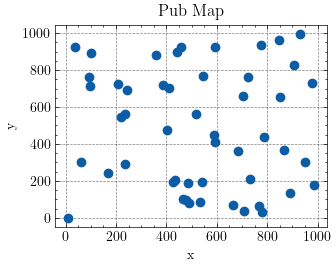

In [4]:
showPubMap(Pubs)

In [5]:
currentTime = 10

# show waiting times for all pubs
for p in Pubs:
    print('Pub ID: ', p.pubID, ' Waiting Time: ', p.getWaitingTime(currentTime))

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

In [ ]:
currT = np.linspace(0, 1000, 100)

# evaluate the waiting time for all pubs at different times
for p in Pubs:
    waitingTimes = []
    for t in currT:
        waitingTimes.append(p.getWaitingTime(t))
    plt.plot(currT, waitingTimes, 'o', label=p.pubID)
    plt.xlabel('Time')
    plt.ylabel('Waiting Time')
    plt.title('Waiting Times')
    plt.legend()

# plot wainting times for all pubs in a subplot


# create a figure with subplots



# Implementation of the Ant-Colony Optimization

1.) Init the pheromone and visibility matrix


In [ ]:
# Use the random pubs
Pubs = PCF.initPubs('RandomPubs.csv')


In [ ]:
# simulation paramters
tau0 = 1
alpha = 1
beta = 1
gamma = 1 
rho = 0.2

# simulation counters
time = 0
timeMax = int(60*12)            # 12 hours in minutes - 3pm to 3am 
iter = 0
# population size of ants
popSize = 100

# velocity of an ant
velAnt = 1


In [ ]:
# init the pheromone matrix which is a 2D array with the size of the number of pubs
pheromoneMatrix = np.ones((len(Pubs), len(Pubs)))
pheromoneMatrix = pheromoneMatrix * tau0


# the visibility matrix is in this case not only the distance between the pubs, but also takes into consideration
# the waiting time at the next pub
# we inititalize the matrix at time = 0

# init the distance matrix D
distanceMatrix = np.zeros((len(Pubs), len(Pubs)))
for i in range(len(Pubs)):
    for j in range(i, len(Pubs)):
        distanceMatrix[i][j] = PCF.getDistance(Pubs[i], Pubs[j])
        #  print("i and j: ", i, j, " distance: ", distanceMatrix[i][j])

        distanceMatrix[j][i] = distanceMatrix[i][j]

# set the diagonal to 10e15
for i in range(len(Pubs)):
    distanceMatrix[i][i] = 10e15

# init the visibility matrix
visibilityMatrix = 1 / distanceMatrix

## Test the ACO without time dependecy, for this set timeMatrix = ones and gamma = 1

In [ ]:
pathCollection = np.zeros((popSize, len(Pubs)))
pathLengthCollection = np.zeros((popSize, 1))

minimumPathLength = int(10e15)
minimumPath = np.zeros(len(Pubs))

Plotting = False

if Plotting:
    # init a plot for the path
    plt.figure(figsize=(8, 8))
    plt.title('Pub Crawl')
    plt.xlabel('x')
    plt.ylabel('y')

    # plot all pubs
    x = [pub.posX for pub in Pubs]
    y = [pub.posY for pub in Pubs]
    pubs_scatter = plt.scatter(x, y)

    # plot the connections between the pubs
    connection_lines, = plt.plot([], [], 'k-')


# clear the log file
Logger.clearLog()


while(True):
    iter += 1

    # Generate paths
    for i in range(popSize):
        path = PCF.generatePath(pheromoneMatrix, visibilityMatrix, waitingTimes, alpha, beta, gamma, Pubs)
        pathLength = PCF.getPathLength(path, Pubs)

        # update the minimal path
        if pathLength < minimumPathLength:
            minimumPathLength = pathLength
            minimumPath = path

            # inform the user
            print('New minimum path found, in iteration: ', minimumPathLength, iter)
            print("Path: ", minimumPath)

            # log the new minimum path
            Logger.logBestPath(minimumPath, minimumPathLength)

            if Plotting:
                # update scatter plot
                x = [Pubs[pubID].posX for pubID in minimumPath]
                y = [Pubs[pubID].posY for pubID in minimumPath]
                pubs_scatter.set_offsets(np.column_stack((x, y)))

                # update connection lines
                connection_lines.set_xdata(x)
                connection_lines.set_ydata(y)

                # update the title
                plt.title('Pub Crawl - Length: ' + str(minimumPathLength))

                plt.pause(0.01)



        pathCollection[i,:] = path
        pathLengthCollection[i] = pathLength

    # update the pheromone matrix
    deltaPheromoneMatrix = PCF.getDeltaPheromoneMatrix(pathCollection, pathLengthCollection)
    pheromoneMatrix = PCF.updatePheromoneMatrix(pheromoneMatrix, deltaPheromoneMatrix, rho)



In [ ]:
# plot the best path
# load the best path from the log files

counter = 4

bestPathPath = "Logs/BestPath_" + str(counter) + ".csv"
# read the last line of the file
with open(bestPathPath, 'r') as f:
    lines = f.readlines()
    last_line = lines[-1]
    bestPath = last_line


# parse the bestPath, the first element is before the "," the second after
bestPathOrigin = bestPath.split(',')
# convert the first element to an array of intergers, delimited by ;
bestPath = np.array(bestPathOrigin[0].split(';')).astype(int)
bestPathLength = bestPathOrigin[1]

# plot the best path
fig = PCF.plotPath(bestPath, Pubs)
plt.title('Best Path')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



In [ ]:
print('Distance Matrix: ', distanceMatrix)

print('Pheromone Matrix: ', pheromoneMatrix)

print('Waiting vector: ', PCF.getWaitingVector(Pubs, time))

print('Waiting vector: ', PCF.getWaitingVector(Pubs, 100))

